In [24]:
import psycopg2 #for database connection
import pandas as pd 
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt # for plotting
import json

# Kruskal-Wallis analysis of variance
import scipy.stats as ss # For Kruskal-Wallis test
import scikit_posthocs as sp #For post hoc tests. 
from termcolor import colored # for coloring the print text
import warnings # to ignore plot warnings

# For ggplot
from plotnine import *

# For bolding the printed text
from termcolor import colored

In [25]:
# Define database
hostname = 'localhost'
# f = open("Username.txt", "r")
# username = f.read()
# password = f.read()
database = 'phishdatabase'
username = 'postgres'
password = 'postgres'
port = "5432"

In [26]:
# Create Connection
try:
    connection = psycopg2.connect( host=hostname, user=username, password=password, dbname=database, port=port )
    
    
except:
    print("I am unable to connect to the database")

In [27]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [28]:
# Step 1
# Getting gold standard images
gold_std = pd.read_sql_query("select subject_id, filename, malicious, gold_std from cybertrust_zooniverse_datamatch where gold_std is true", connection)
gold_std

C:\Users\#3\AppData\Local\Temp\ipykernel_17968\2820034461.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,subject_id,filename,malicious,gold_std
0,43857918,BoA2(1).jpg,True,True
1,43861756,GoogleDoc.jpg,True,True
2,43857092,UPRailRoad.png,False,True
3,43857086,TaxInformationEmail.png,True,True
4,43857079,Paypal.png,True,True
...,...,...,...,...
27,43857066,ebay.png,True,True
28,43857064,Dropbox.png,True,True
29,43857063,Discover.png,True,True
30,43857061,craigslist.png,True,True


In [29]:
sql = """select c.subject_ids as subject_id, a.annotations->>'value' as user_answers 
       from zooniverse_phish_classifications as c, 
    jsonb_array_elements(c.annotations) as a(annotations)
    where a.annotations->>'task' = 'T0'
"""

zooniverseclassification = pd.read_sql_query(sql, connection)
zooniverseclassification

C:\Users\#3\AppData\Local\Temp\ipykernel_17968\1374761481.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,subject_id,user_answers
0,43857074,"[{""x"": 655.9531860351562, ""y"": 339.36654663085..."
1,43857087,"[{""x"": 184.76377868652344, ""y"": 28.77332878112..."
2,43856989,"[{""x"": 120.6994857788086, ""y"": 24.617567062377..."
3,43857081,"[{""x"": 737.415771484375, ""y"": 352.486724853515..."
4,43857096,"[{""x"": 1083.43896484375, ""y"": 514.370239257812..."
...,...,...
12738,49251702,"[{""x"": 823.7265014648438, ""y"": 354.96710205078..."
12739,49251698,"[{""x"": 746.512451171875, ""y"": 352.313629150390..."
12740,52846951,"[{""x"": 947.9085693359375, ""y"": 80.652969360351..."
12741,52844558,"[{""x"": 247.52639770507812, ""y"": 497.6387939453..."


In [30]:
usercues = pd.DataFrame(columns=["user_labeled_image", "subject_id", "cue"])
for user_labeled_image in range(0, len(zooniverseclassification["user_answers"])):
    current_string = zooniverseclassification["user_answers"][user_labeled_image]
    json_object = json.loads(current_string)
    
    for item in json_object:
        data_input = {"user_labeled_image": user_labeled_image, 
                            "subject_id": zooniverseclassification["subject_id"][user_labeled_image], 
                            "cue": item["tool_label"]}   
        
        usercues.loc[len(usercues.index)] = data_input

usercues

,user_labeled_image,subject_id,cue
0,0,43857074,Invalid Domain or Sender
1,0,43857074,Potentially Malicious Link
2,0,43857074,Appeal to Action-Authority
3,1,43857087,Invalid Domain or Sender
4,1,43857087,Poor Spelling or Grammar
...,...,...,...
23572,12740,52846951,Invalid Domain or Sender
23573,12740,52846951,Invalid Domain or Sender
23574,12740,52846951,Invalid Domain or Sender
23575,12740,52846951,Invalid Domain or Sender


In [31]:
usercues = usercues.drop_duplicates()

In [32]:
sortedcues = usercues.groupby('subject_id').apply(lambda x: pd.Series(
    dict(Invalid_Domain_or_Sender = (x.cue == "Invalid Domain or Sender").sum(),
         Potent_Mal_Links = (x.cue == "Potentially Malicious Link").sum(),
         Spelling_or_Grammar = (x.cue == "Poor Spelling or Grammar").sum(),
         Appeal_to_Greed = (x.cue == "Appeal to Action-Greed").sum(),
         Appeal_to_Urgency = (x.cue == "Appeal to Action-Urgency").sum(),
         Appeal_to_Authority = (x.cue == "Appeal to Action-Authority").sum(),
         Other_Phishy_Findings = (x.cue == "Other Phishy Findings").sum()
    ))).reset_index('subject_id')

sortedcues = pd.DataFrame(sortedcues)
sortedcues

,subject_id,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings
0,43856939,1,0,0,3,0,0,1
1,43856944,7,1,0,2,0,0,3
2,43856946,1,0,0,4,0,0,2
3,43856947,8,1,2,0,0,0,0
4,43856950,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1693,52847470,0,0,4,0,0,0,3
1694,52847471,0,0,2,0,0,0,3
1695,52847473,1,0,2,0,0,1,2
1696,52847476,0,0,0,0,0,0,3


In [33]:
change_type ={"subject_id": "int64"}
sortedcues = sortedcues.astype(change_type)
data_types = sortedcues.dtypes
data_types

subject_id                  int64
Invalid_Domain_or_Sender    int64
Potent_Mal_Links            int64
Spelling_or_Grammar         int64
Appeal_to_Greed             int64
Appeal_to_Urgency           int64
Appeal_to_Authority         int64
Other_Phishy_Findings       int64
dtype: object

In [34]:
sql = """select c.subject_ids as subject_id, a.annotations->>'value' as zoo_trust 
       from zooniverse_phish_classifications as c, 
    jsonb_array_elements(c.annotations) as a(annotations)
    where a.annotations->>'task' = 'T3'"""

classificationsession = pd.read_sql_query(sql, connection)
classificationsession['subject_id'] = classificationsession['subject_id'].astype('int64')

classificationsession['zoo_trust_b'] = (classificationsession['zoo_trust'] == "Nothing Phishy Here")

classificationsession

C:\Users\#3\AppData\Local\Temp\ipykernel_17968\1008629850.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,subject_id,zoo_trust,zoo_trust_b
0,43857001,Nothing Phishy Here,True
1,43857012,Nothing Phishy Here,True
2,43857072,Nothing Phishy Here,True
3,43857007,Nothing Phishy Here,True
4,43857095,None,False
...,...,...,...
31364,52844553,None,False
31365,52846983,None,False
31366,52846998,None,False
31367,52846937,None,False


In [35]:
z_total_people_df = classificationsession.groupby('subject_id').apply(lambda x: pd.Series(
               dict(z_total_people = (x.zoo_trust_b ==  True).sum() + (x.zoo_trust_b == False).sum()))).reset_index('subject_id')
z__total_people_df = pd.DataFrame(z_total_people_df)

z_total_people_df

,subject_id,z_total_people
0,43856939,15
1,43856944,16
2,43856946,16
3,43856947,16
4,43856950,17
...,...,...
2022,52847471,15
2023,52847473,15
2024,52847474,15
2025,52847476,15


In [36]:
z_trust_no_trust = classificationsession.groupby('subject_id').apply(lambda x: pd.Series(
               dict(z_trust = (x.zoo_trust_b ==  True).sum(),
                    z_no_trust =(x.zoo_trust_b == False).sum()
                    ))).reset_index('subject_id')
z_trust_no_trust = pd.DataFrame(z_trust_no_trust)

z_trust_no_trust

z_trust_no_trust[z_trust_no_trust['subject_id']== 52838136]

,subject_id,z_trust,z_no_trust
665,52838136,12,3


In [52]:
sortedcues = pd.merge(sortedcues, z_trust_no_trust, on= 'subject_id')
sortedcues = pd.merge(sortedcues, z__total_people_df, on= 'subject_id')

sortedcues[sortedcues['subject_id']== 52838136]


,subject_id,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings,z_trust_x,z_no_trust_x,z_total_people_x,filename,malicious,gold_std,z_trust_y,z_no_trust_y,z_total_people_y
612,52838136,3,0,0,0,0,0,1,12,3,15,hp460.jpg,True,False,12,3,15


In [38]:
All_images = pd.read_sql_query("select subject_id, filename, malicious, gold_std from cybertrust_zooniverse_datamatch", connection)
All_images

C:\Users\#3\AppData\Local\Temp\ipykernel_17968\1455705220.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,subject_id,filename,malicious,gold_std
0,52837250,hp86.jpg,True,False
1,52837251,hp87.jpg,True,False
2,52837253,hp88.jpg,True,False
3,52837254,hp89.jpg,True,False
4,52837255,hp90.jpg,True,False
...,...,...,...,...
1990,52847471,ht1071.jpg,False,False
1991,52847473,ht1072.jpg,False,False
1992,52847474,ht1073.jpg,False,False
1993,52847476,ht1074.jpg,False,False


In [39]:
All_images[~All_images["malicious"]]

,subject_id,filename,malicious,gold_std
694,43857052,65.jpg,False,False
695,43857054,66.jpg,False,False
696,43857055,67.jpg,False,False
697,43857057,68.jpg,False,False
716,43856975,19.jpg,False,False
...,...,...,...,...
1990,52847471,ht1071.jpg,False,False
1991,52847473,ht1072.jpg,False,False
1992,52847474,ht1073.jpg,False,False
1993,52847476,ht1074.jpg,False,False


In [40]:
sortedcues = pd.merge(sortedcues, All_images, on='subject_id')
sortedcues[sortedcues['malicious']]


,subject_id,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings,z_trust,z_no_trust,z_total_people,filename,malicious,gold_std
0,43856939,1,0,0,3,0,0,1,9,6,15,1.jpg,True,False
1,43856944,7,1,0,2,0,0,3,5,11,16,2.jpg,True,False
2,43856946,1,0,0,4,0,0,2,9,7,16,3.jpg,True,False
3,43856947,8,1,2,0,0,0,0,4,12,16,4.jpg,True,False
4,43856950,1,0,0,0,0,0,0,15,2,17,5.jpg,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,52838773,4,0,3,0,1,1,1,7,8,15,hp813.jpg,True,False
891,52838774,10,0,2,0,0,3,8,4,11,15,hp814.jpg,True,False
892,52838775,8,0,12,2,1,0,2,0,15,15,hp815.jpg,True,False
893,52838777,13,0,9,0,0,0,5,0,15,15,hp816.jpg,True,False


In [41]:

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each threshold value
for n in range(1,27):
    # Filter the DataFrame based on the boolean statement being true
    filtered_df = sortedcues[sortedcues['malicious']]
    
    # Count how many times each column has values above or equal to n
    count_above_n = (filtered_df.iloc[:, 1:8] >= n).sum()
    
    # Convert counts to percentages
    percentages = count_above_n / 856

    # Create a DataFrame for the current threshold value
    result_df = pd.DataFrame({
        'n': [n],
        'Invalid_Domain_or_Sender': [percentages['Invalid_Domain_or_Sender']],
        'Potent_Mal_Links': [percentages['Potent_Mal_Links']],
        'Spelling_or_Grammar': [percentages['Spelling_or_Grammar']],
        'Appeal_to_Greed': [percentages['Appeal_to_Greed']],
        'Appeal_to_Urgency': [percentages['Appeal_to_Urgency']],
        'Appeal_to_Authority': [percentages['Appeal_to_Authority']],
        'Other_Phishy_Findings': [percentages['Other_Phishy_Findings']]
    })
    
    # Append the DataFrame to the list
    dfs.append(result_df)

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)

results_df


,n,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings
0,1,0.967290,0.026869,0.655374,0.310748,0.331776,0.505841,0.914720
1,2,0.925234,0.018692,0.455607,0.156542,0.167056,0.240654,0.757009
2,3,0.865654,0.015187,0.314252,0.098131,0.110981,0.130841,0.585280
3,4,0.825935,0.012850,0.227804,0.065421,0.078271,0.064252,0.443925
4,5,0.775701,0.011682,0.163551,0.044393,0.063084,0.023364,0.316589
...,...,...,...,...,...,...,...,...
21,22,0.002336,0.001168,0.002336,0.000000,0.001168,0.000000,0.000000
22,23,0.002336,0.000000,0.002336,0.000000,0.001168,0.000000,0.000000
23,24,0.002336,0.000000,0.001168,0.000000,0.001168,0.000000,0.000000
24,25,0.001168,0.000000,0.001168,0.000000,0.000000,0.000000,0.000000


In [42]:
#results_df.to_csv("true_positive_rate_per_N_people.csv", index=False)

In [43]:
# Initialize an empty list to store DataFrames
dfs_2 = []

# Iterate over each threshold value
for n in range(1,27):
    # Filter the DataFrame based on the boolean statement being true
    filtered_df = sortedcues[~sortedcues['malicious']]
    
    # Count how many times each column has values above or equal to n
    count_above_n = (filtered_df.iloc[:, 1:8] >= n).sum()
    
    # Convert counts to percentages
    percentages = count_above_n / 1139

    # Create a DataFrame for the current threshold value
    result_df_2 = pd.DataFrame({
        'n': [n],
        'Invalid_Domain_or_Sender': [percentages['Invalid_Domain_or_Sender']],
        'Potent_Mal_Links': [percentages['Potent_Mal_Links']],
        'Spelling_or_Grammar': [percentages['Spelling_or_Grammar']],
        'Appeal_to_Greed': [percentages['Appeal_to_Greed']],
        'Appeal_to_Urgency': [percentages['Appeal_to_Urgency']],
        'Appeal_to_Authority': [percentages['Appeal_to_Authority']],
        'Other_Phishy_Findings': [percentages['Other_Phishy_Findings']]
    })
    
    # Append the DataFrame to the list
    dfs_2.append(result_df_2)

# Concatenate all DataFrames in the list
results_df_2 = pd.concat(dfs_2, ignore_index=True)

results_df_2

,n,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings
0,1,0.262511,0.017559,0.292362,0.199298,0.125549,0.131694,0.524144
1,2,0.122037,0.010536,0.105356,0.072871,0.030729,0.026339,0.270413
2,3,0.065847,0.007902,0.046532,0.034241,0.010536,0.008780,0.127305
3,4,0.042142,0.005268,0.028095,0.013169,0.005268,0.004390,0.060579
4,5,0.028095,0.004390,0.020193,0.006146,0.003512,0.003512,0.036874
...,...,...,...,...,...,...,...,...
21,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
#results_df.to_csv("true_negative_rate_per_N_people.csv", index=False)

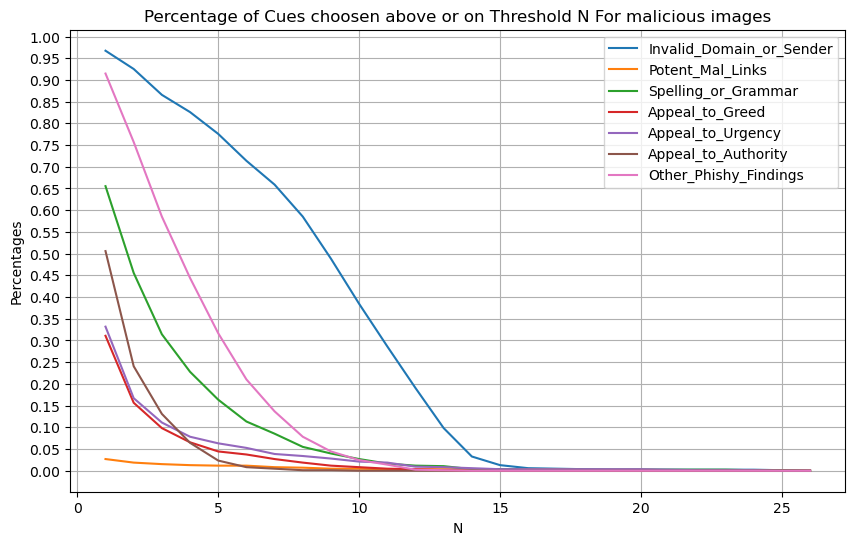

In [45]:


# Plotting
plt.figure(figsize=(10, 6))

# Plot each column's percentages
for col in results_df.columns[1:]:
    plt.plot(results_df['n'], results_df[col], label=col)

plt.xlabel('N')
plt.ylabel('Percentages')
plt.title('Percentage of Cues choosen above or on Threshold N For malicious images')

# Set y-axis ticks to increments of 0.1
plt.yticks([i/100 for i in range(0, 101, 5)])

plt.legend()
plt.grid(True)
plt.show()


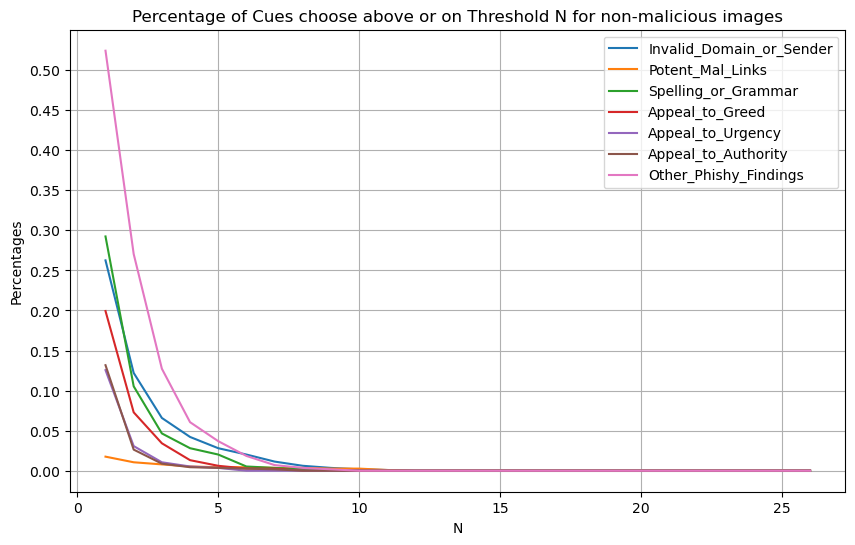

In [46]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot each column's percentages
for col in results_df_2.columns[1:]:
    plt.plot(results_df_2['n'], results_df_2[col], label=col)

plt.xlabel('N')
plt.ylabel('Percentages')
plt.title('Percentage of Cues choose above or on Threshold N for non-malicious images')

plt.yticks([i/100 for i in range(0, 51, 5)])

plt.legend()
plt.grid(True)
plt.show()

In [47]:
gold_std = sortedcues[sortedcues["gold_std"]]
gold_std[~gold_std['malicious']]

,subject_id,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings,z_trust,z_no_trust,z_total_people,filename,malicious,gold_std
58,43857067,2,11,5,0,0,7,1,3,14,17,EmmailFialure.png,False,True
60,43857071,1,3,1,1,5,0,2,8,7,15,Firmoo.png,False,True
61,43857072,2,10,4,0,0,0,3,3,12,15,gmail.png,False,True
63,43857077,1,0,0,0,0,0,0,12,3,15,Newsweek.png,False,True
65,43857080,0,2,0,0,0,0,2,11,5,16,Snapchat.png,False,True
67,43857083,2,3,0,0,1,0,5,6,8,14,SprintBill.png,False,True
68,43857084,1,4,0,0,2,0,1,9,6,15,subject-303.png,False,True
72,43857090,1,0,1,0,0,0,2,11,4,15,Twitter.png,False,True
73,43857092,5,8,1,0,0,1,2,4,12,16,UPRailRoad.png,False,True
74,43857093,3,6,4,2,5,2,6,22,29,51,UPS.png,False,True


In [48]:
# Initialize an empty list to store DataFrames
dfs_3 = []

# Iterate over each threshold value
for n in range(1,27):
    # Filter the DataFrame based on the boolean statement being true
    filtered_df = gold_std[gold_std['malicious']]
    
    # Count how many times each column has values above or equal to n
    count_above_n = (filtered_df.iloc[:, 1:8] >= n).sum()
    
    # Convert counts to percentages
    percentages = count_above_n / 18

    # Create a DataFrame for the current threshold value
    result_df_3 = pd.DataFrame({
        'n': [n],
        'Invalid_Domain_or_Sender': [percentages['Invalid_Domain_or_Sender']],
        'Potent_Mal_Links': [percentages['Potent_Mal_Links']],
        'Spelling_or_Grammar': [percentages['Spelling_or_Grammar']],
        'Appeal_to_Greed': [percentages['Appeal_to_Greed']],
        'Appeal_to_Urgency': [percentages['Appeal_to_Urgency']],
        'Appeal_to_Authority': [percentages['Appeal_to_Authority']],
        'Other_Phishy_Findings': [percentages['Other_Phishy_Findings']]
    })
    
    # Append the DataFrame to the list
    dfs_3.append(result_df_3)

# Concatenate all DataFrames in the list
results_df_3 = pd.concat(dfs_3, ignore_index=True)

results_df_3

,n,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings
0,1,0.944444,0.888889,0.944444,0.333333,0.611111,0.500000,0.888889
1,2,0.944444,0.833333,0.555556,0.166667,0.555556,0.277778,0.777778
2,3,0.888889,0.722222,0.500000,0.055556,0.444444,0.222222,0.555556
3,4,0.833333,0.611111,0.444444,0.055556,0.444444,0.166667,0.500000
4,5,0.833333,0.555556,0.388889,0.055556,0.388889,0.111111,0.333333
...,...,...,...,...,...,...,...,...
21,22,0.111111,0.055556,0.111111,0.000000,0.055556,0.000000,0.000000
22,23,0.111111,0.000000,0.111111,0.000000,0.055556,0.000000,0.000000
23,24,0.111111,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000
24,25,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000


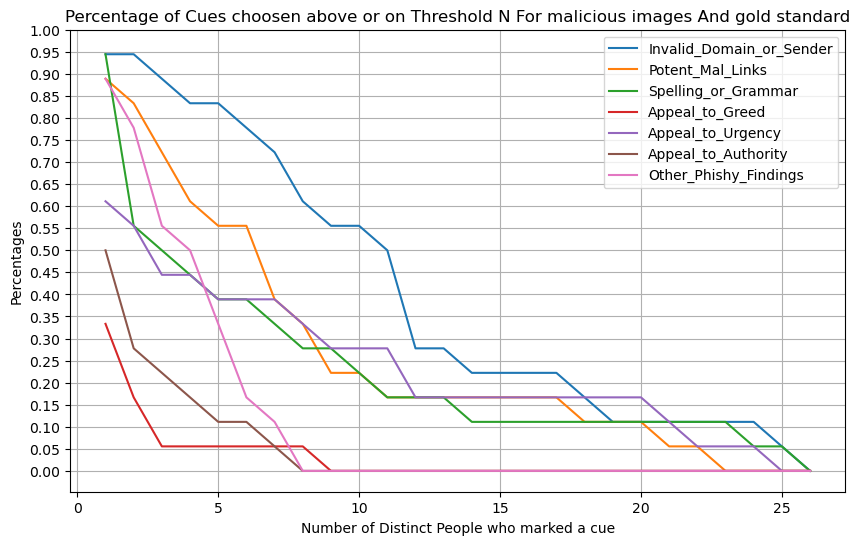

In [49]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot each column's percentages
for col in results_df_3.columns[1:]:
    plt.plot(results_df_3['n'], results_df_3[col], label=col)

plt.xlabel('Number of Distinct People who marked a cue')
plt.ylabel('Percentages')
plt.title('Percentage of Cues choosen above or on Threshold N For malicious images And gold standard')

# Set y-axis ticks to increments of 0.1
plt.yticks([i/100 for i in range(0, 101, 5)])

plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Initialize an empty list to store DataFrames
dfs_4 = []

# Iterate over each threshold value
for n in range(1,27):
    # Filter the DataFrame based on the boolean statement being true
    filtered_df = gold_std[~gold_std['malicious']]
    
    # Count how many times each column has values above or equal to n
    count_above_n = (filtered_df.iloc[:, 1:8] >= n).sum()
    
    # Convert counts to percentages
    percentages = count_above_n / 13

    # Create a DataFrame for the current threshold value
    result_df_4 = pd.DataFrame({
        'n': [n],
        'Invalid_Domain_or_Sender': [percentages['Invalid_Domain_or_Sender']],
        'Potent_Mal_Links': [percentages['Potent_Mal_Links']],
        'Spelling_or_Grammar': [percentages['Spelling_or_Grammar']],
        'Appeal_to_Greed': [percentages['Appeal_to_Greed']],
        'Appeal_to_Urgency': [percentages['Appeal_to_Urgency']],
        'Appeal_to_Authority': [percentages['Appeal_to_Authority']],
        'Other_Phishy_Findings': [percentages['Other_Phishy_Findings']]
    })
    
    # Append the DataFrame to the list
    dfs_4.append(result_df_4)

# Concatenate all DataFrames in the list
results_df_4 = pd.concat(dfs_4, ignore_index=True)

results_df_4

,n,Invalid_Domain_or_Sender,Potent_Mal_Links,Spelling_or_Grammar,Appeal_to_Greed,Appeal_to_Urgency,Appeal_to_Authority,Other_Phishy_Findings
0,1,0.846154,0.769231,0.692308,0.230769,0.384615,0.307692,0.923077
1,2,0.538462,0.692308,0.307692,0.076923,0.307692,0.230769,0.769231
2,3,0.230769,0.615385,0.307692,0.000000,0.230769,0.153846,0.384615
3,4,0.076923,0.461538,0.307692,0.000000,0.230769,0.153846,0.230769
4,5,0.076923,0.384615,0.153846,0.000000,0.230769,0.153846,0.230769
...,...,...,...,...,...,...,...,...
21,22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


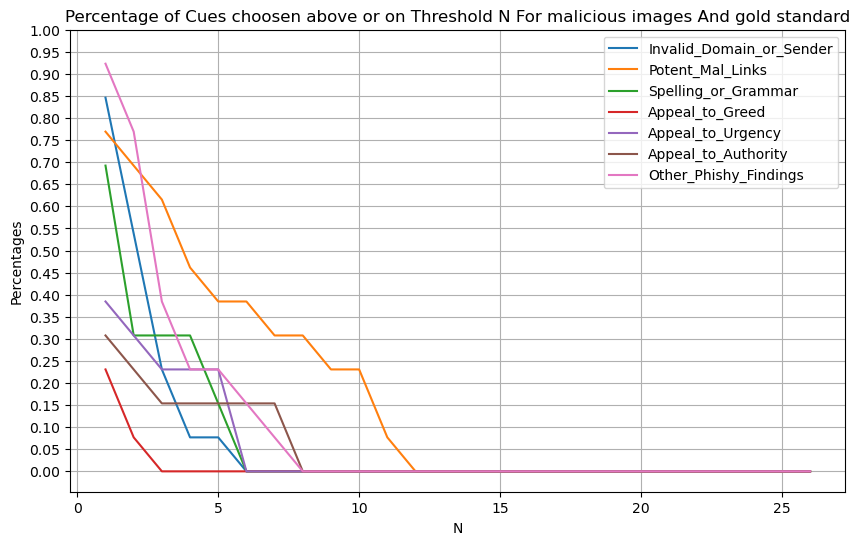

In [51]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot each column's percentages
for col in results_df_4.columns[1:]:
    plt.plot(results_df_4['n'], results_df_4[col], label=col)

plt.xlabel('N')
plt.ylabel('Percentages')
plt.title('Percentage of Cues choosen above or on Threshold N For malicious images And gold standard')

# Set y-axis ticks to increments of 0.1
plt.yticks([i/100 for i in range(0, 101, 5)])

plt.legend()
plt.grid(True)
plt.show()